# Vorlesung 4: Korrelation & Zusammenhang


In [7]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [8]:
plt.style.use("seaborn-v0_8-whitegrid")

csv_path = "OECD.WISE.WDP,DSD_HSL@DF_HSL_CWB,+all.csv"
df = pd.read_csv(csv_path, low_memory=False)

unnamed_cols = [c for c in df.columns if "unnamed" in c.lower()]
if unnamed_cols:
    df = df.drop(columns=unnamed_cols)

df = df.rename(
    columns={
        "REF_AREA": "country",
        "MEASURE": "measure",
        "UNIT_MEASURE": "unit",
        "TIME_PERIOD": "year",
        "OBS_VALUE": "value",
    }
)

df["year"] = pd.to_numeric(df["year"], errors="coerce")
df["value"] = pd.to_numeric(df["value"], errors="coerce")
for cat_col in ("country", "measure", "unit"):
    if cat_col in df.columns:
        df[cat_col] = df[cat_col].astype("category")

df_country_mean = (
    df.groupby(["country", "year"])["value"]
      .mean()
      .reset_index()
      .dropna(subset=["year", "value"])
)

country_code = "DEU"  # nach Bedarf anpassen


/var/folders/24/3x5ck8nn5ks3gh02slld9nn00000gn/T/ipykernel_64899/1690322330.py:27: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  df.groupby(["country", "year"])["value"]


In [ ]:

corr_all_pearson  = df_country_mean[["year","value"]].corr().loc["year","value"]
corr_all_spearman = df_country_mean[["year","value"]].corr(method="spearman").loc["year","value"]

print(f"Gesamt-Korrelation (Pearson):  {corr_all_pearson: .3f}")
print(f"Gesamt-Korrelation (Spearman): {corr_all_spearman: .3f}")

def _corr_row(g):
    g = g.dropna(subset=["year","value"]).sort_values("year")
    n = len(g)
    if n < 3:
        return pd.Series(dict(n_years=n, r_pearson=np.nan, r_spearman=np.nan, slope=np.nan))
    r_p = g[["year","value"]].corr().iloc[0,1]
    r_s = g[["year","value"]].corr(method="spearman").iloc[0,1]
    # einfache lineare Trendsteigung (pro Jahr)
    x = g["year"].to_numpy(dtype=float); y = g["value"].to_numpy(dtype=float)
    slope = np.polyfit(x, y, 1)[0] if len(x) >= 2 else np.nan
    return pd.Series(dict(n_years=n, r_pearson=r_p, r_spearman=r_s, slope=slope))

corr_by_country = df_country_mean.groupby("country").apply(_corr_row).reset_index()

# nützliche Sichten
corr_top_pos = corr_by_country.sort_values("r_pearson", ascending=False).head(10)
corr_top_neg = corr_by_country.sort_values("r_pearson", ascending=True ).head(10)

corr_by_country.head()  # Übersicht


Gesamt-Korrelation (Pearson):  -0.120
Gesamt-Korrelation (Spearman): -0.204


/var/folders/24/3x5ck8nn5ks3gh02slld9nn00000gn/T/ipykernel_64899/482446759.py:21: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  corr_by_country = df_country_mean.groupby("country").apply(_corr_row).reset_index()
/var/folders/24/3x5ck8nn5ks3gh02slld9nn00000gn/T/ipykernel_64899/482446759.py:21: FutureWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  corr_by_country = df_country_mean.groupby("country").apply(_corr_row).reset_index()


,country,n_years,r_pearson,r_spearman,slope
0,ARG,21.0,0.178260,0.137662,0.074665
1,AUS,22.0,-0.100367,-0.079616,-17.188500
2,AUT,21.0,-0.355331,-0.361039,-32.539977
3,BEL,21.0,-0.117758,-0.405195,-21.902063
4,BGR,21.0,-0.604680,-0.307792,-7.419989


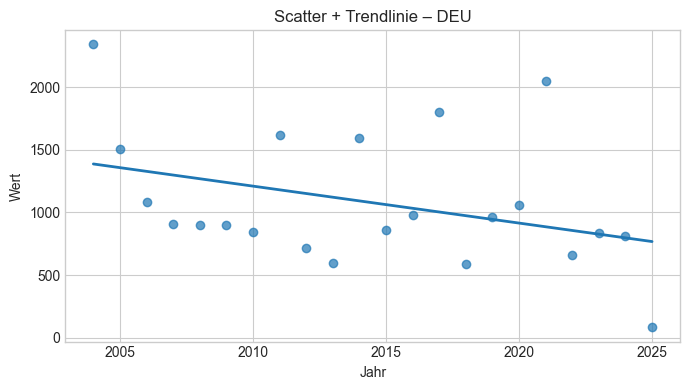

In [10]:
country_code = "DEU"  # <- Land wählen (z.B. "LUX","AUS","BEL","GBR","USA",...)
g = df_country_mean[df_country_mean["country"]==country_code].dropna(subset=["year","value"]).sort_values("year")

plt.figure(figsize=(7,4))
plt.scatter(g["year"], g["value"], alpha=0.7)
if len(g) >= 2:
    x = g["year"].to_numpy(dtype=float); y = g["value"].to_numpy(dtype=float)
    m,b = np.polyfit(x, y, 1)
    xx = np.linspace(x.min(), x.max(), 100)
    yy = m*xx + b
    plt.plot(xx, yy, linewidth=2)
plt.title(f"Scatter + Trendlinie – {country_code}")
plt.xlabel("Jahr"); plt.ylabel("Wert"); plt.tight_layout(); plt.show()


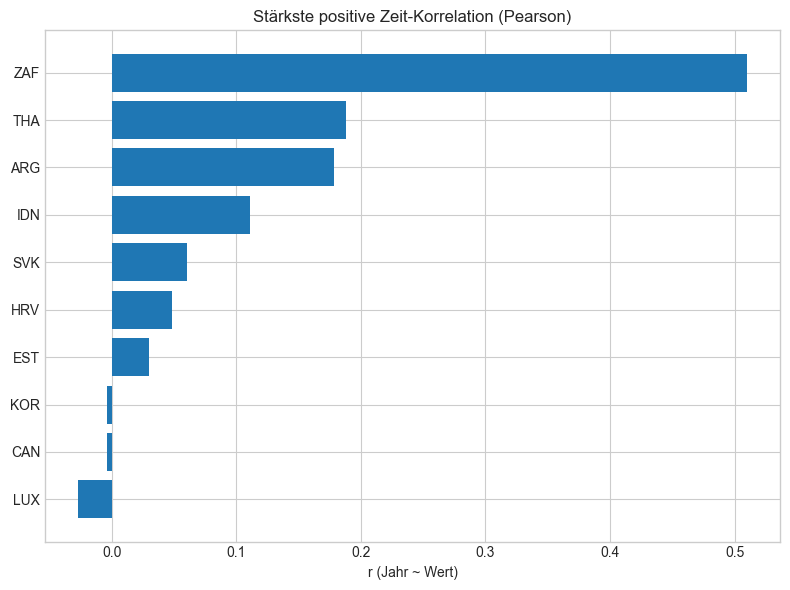

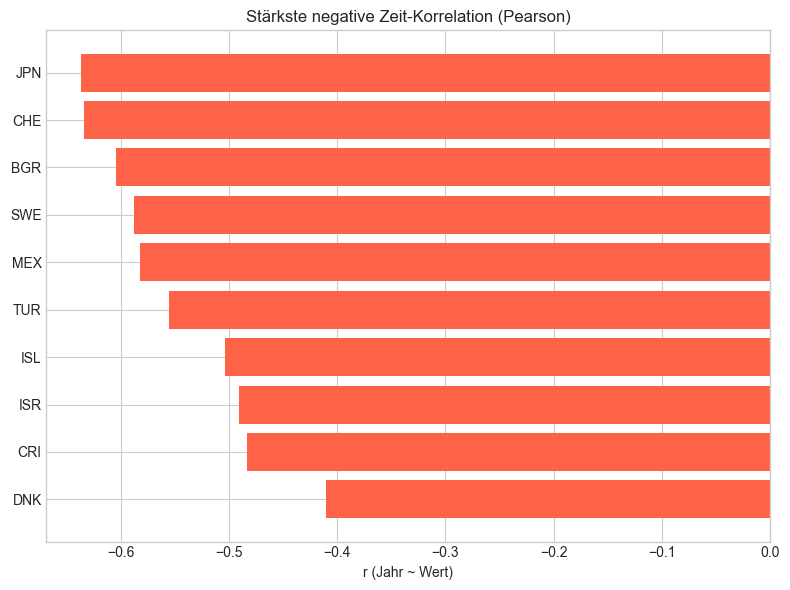

In [11]:
# nur Länder mit genügend Jahren
cb = corr_by_country[corr_by_country["n_years"]>=5].copy()

# TOP 10 positiv & negativ (Pearson)
top_pos = cb.sort_values("r_pearson", ascending=False).head(10)
top_neg = cb.sort_values("r_pearson", ascending=True ).head(10)

plt.figure(figsize=(8,6))
plt.barh(top_pos["country"], top_pos["r_pearson"])
plt.gca().invert_yaxis()
plt.title("Stärkste positive Zeit-Korrelation (Pearson)")
plt.xlabel("r (Jahr ~ Wert)"); plt.tight_layout(); plt.show()

plt.figure(figsize=(8,6))
plt.barh(top_neg["country"], top_neg["r_pearson"], color="tomato")
plt.gca().invert_yaxis()
plt.title("Stärkste negative Zeit-Korrelation (Pearson)")
plt.xlabel("r (Jahr ~ Wert)"); plt.tight_layout(); plt.show()

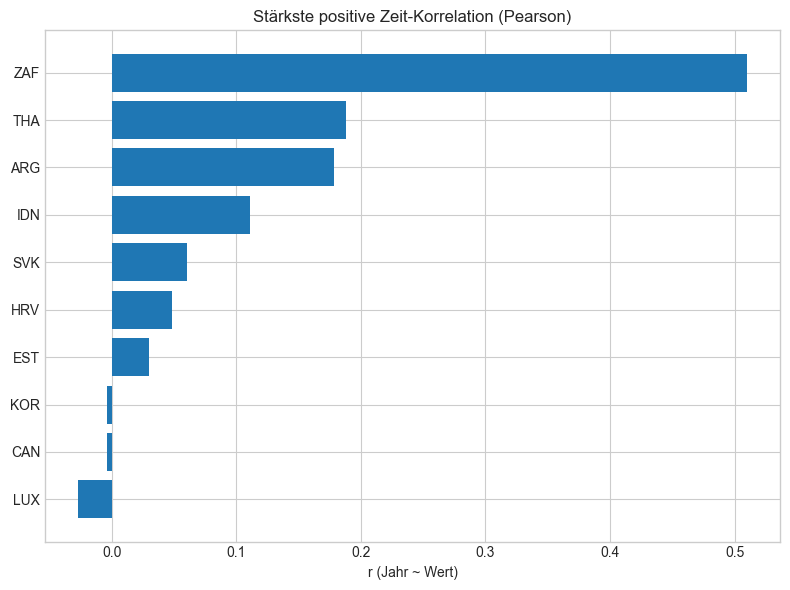

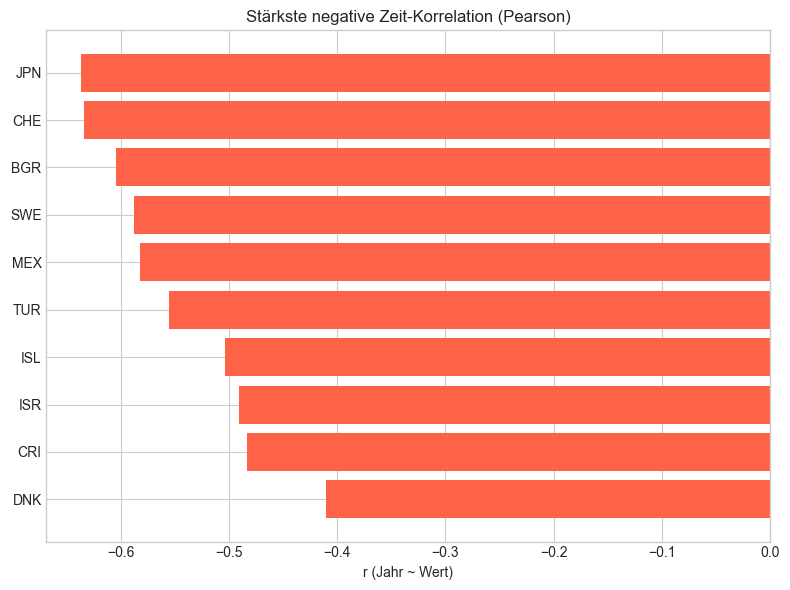

In [12]:
# nur Länder mit genügend Jahren
cb = corr_by_country[corr_by_country["n_years"]>=5].copy()

# TOP 10 positiv & negativ (Pearson)
top_pos = cb.sort_values("r_pearson", ascending=False).head(10)
top_neg = cb.sort_values("r_pearson", ascending=True ).head(10)

plt.figure(figsize=(8,6))
plt.barh(top_pos["country"], top_pos["r_pearson"])
plt.gca().invert_yaxis()
plt.title("Stärkste positive Zeit-Korrelation (Pearson)")
plt.xlabel("r (Jahr ~ Wert)"); plt.tight_layout(); plt.show()

plt.figure(figsize=(8,6))
plt.barh(top_neg["country"], top_neg["r_pearson"], color="tomato")
plt.gca().invert_yaxis()
plt.title("Stärkste negative Zeit-Korrelation (Pearson)")
plt.xlabel("r (Jahr ~ Wert)"); plt.tight_layout(); plt.show()

In [13]:
# Proxy-Konfounder: landesspezifisches Niveau (Mittelwert je Land)
lvl = df_country_mean.groupby("country")["value"].transform("mean").rename("lvl")

x = df_country_mean["year"].to_numpy(dtype=float)
y = df_country_mean["value"].to_numpy(dtype=float)
z = lvl.to_numpy(dtype=float)

def _corr(a,b):
    return np.corrcoef(a,b)[0,1]

r_xy = _corr(x,y); r_xz = _corr(x,z); r_yz = _corr(y,z)
# partielle Korrelation r_xy.z (Formel aus VL4)
num = r_xy - r_xz*r_yz
den = np.sqrt((1 - r_xz**2)*(1 - r_yz**2))
r_partial = num/den if den>0 else np.nan
print(f"Partielle Korrelation r(year,value | level): {r_partial: .3f}")


Partielle Korrelation r(year,value | level): -0.159


/var/folders/24/3x5ck8nn5ks3gh02slld9nn00000gn/T/ipykernel_64899/3977810131.py:2: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  lvl = df_country_mean.groupby("country")["value"].transform("mean").rename("lvl")
